# Problem 2: MNIST Image Classification

In [2]:
%matplotlib inline
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from skimage.transform import resize

In [3]:
mndata = MNIST('./data/mnist/')

In [4]:
def showImage(pixels, label, shape = (28, 28)):
    pixels = np.array(pixels, dtype='uint8')
    pixels = pixels.reshape(shape)
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

## Part 2A: MNIST using naive Bayes

### Using Normal distribution and untouched images

In [5]:
def aggregateImagesByNumber(images, labels): 
    numberToImages = {}
    for index in range(len(images)):
        label = labels[index]
        if(label not in numberToImages):
            numberToImages[label] = []
        numberToImages[label].append(images[index])
    return numberToImages

In [6]:
def calculateMeanAndVar(data):
    results = []
    for item in zip(*data):
        meanVar = (np.nanmean(item) + 1, np.nanvar(item) + 1)
        results.append(meanVar)
    return results

In [7]:
def calculateMeanAndVarForNumbers(dataByClasses):
    results = {}
    for classValue, values in dataByClasses.items():
        results[classValue] = calculateMeanAndVar(values)
    return results

In [8]:
def calculateProbability(x, mean, var):
    p = 1/(np.sqrt(2*np.pi*var)) * np.exp((-(x-mean)**2)/(2*var))
    return p

In [9]:
def calculateProbabilitiesForNumbers(dataByClasses, imagePixels):
    classProbabilities = {}
    for label, images in dataByClasses.items():
        classProbabilities[label] = 1
        for i in range(len(images)):
            mean, var = images[i]
            inputV = imagePixels[i]
            prob = calculateProbability(inputV, mean, var)
            classProbabilities[label] += prob
    return classProbabilities

In [10]:
def getPrediction(numberSummaries, imagePixels):
    numberProbabilities = calculateProbabilitiesForNumbers(numberSummaries, imagePixels)
    predictedLabel, bestProb = None, -1
    for label, prob in numberProbabilities.items():
        if predictedLabel is None or prob > bestProb:
            predictedLabel = label
            bestProb = prob
    return predictedLabel

In [11]:
def getPredictionsForTestNumbers(numberSummaries, testImages):
    predictions = []
    for imagePixels in tqdm(testImages):
        prediction = getPrediction(numberSummaries, imagePixels)
        predictions.append(prediction)
    return predictions

In [12]:
def getAccuracy(predictions, testData, testLabels):
    accurate = 0
    rows_in_test_set = len(testData)
    for index in range(rows_in_test_set):
        if predictions[index] == testLabels[index]:
            accurate += 1
    return (accurate / rows_in_test_set) * 100

In [13]:
def thresholdOriginalImages(images):
    threshold, upper, lower = 127, 1, 0
    return np.where(np.array(images)>threshold, upper, lower)

In [14]:
def thresholdScaledImages(imagePixels):
    a = imagePixels.copy()
    grey = a[a > 0]
    mid = sum(grey) / len(grey)
    return np.where(np.array(a)>mid, 1, 0)

In [15]:
def resizeImage(imagePixels, size):
    xmax, ymax = np.max(np.where(imagePixels!=0), 1)
    xmin, ymin = np.min(np.where(imagePixels!=0), 1)
    bounding = imagePixels[xmin:xmax,ymin:ymax]
    resized = resize(bounding, size, mode='constant')
    return resized

In [16]:
def train(trainingData, trainingLabels, testData, testLabels):
    splits = 1
    totalAccuracy = 0
    for step in range(splits):
        print("Grouping by class")
        groupedByClass = aggregateImagesByNumber(trainingData, trainingLabels)
        print("Calculating mean and var")
        classSummary = calculateMeanAndVarForNumbers(groupedByClass)
        print("Getting Predictions")
        predictions = getPredictionsForTestNumbers(classSummary, testData)
        print("Getting Accuracy")
        accuracy = getAccuracy(predictions, testData, testLabels)
        totalAccuracy += accuracy
    return totalAccuracy / splits

In [17]:
trainingDataImages, trainingLabels = mndata.load_training()
trainingDataImages = np.array(trainingDataImages).astype(np.uint8)
testDataImages, testLabels = mndata.load_testing()
testDataImages = np.array(testDataImages).astype(np.uint8)
print(f"Loaded {len(trainingDataImages)} training images and {len(testDataImages)} test images")

Loaded 60000 training images and 10000 test images


Applied threshold to training and test images


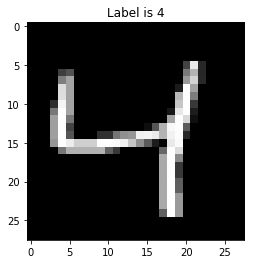

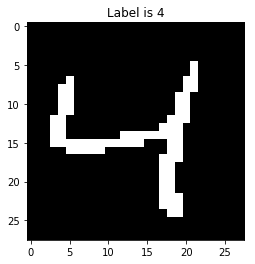

In [18]:
trainingDataCleaned = thresholdOriginalImages(trainingDataImages)
testDataCleaned = thresholdOriginalImages(testDataImages)
print(f"Applied threshold to training and test images")
showImage(trainingDataImages[2], trainingLabels[2])
showImage(trainingDataCleaned[2], trainingLabels[2])

Resizing images to (20, 20)


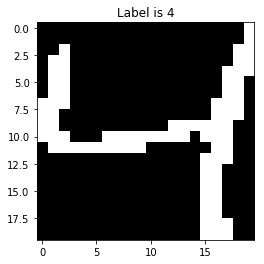

In [26]:
size = (20, 20)
print(f"Resizing images to {size}")
resizedTrainingImages = np.array([np.ravel(thresholdScaledImages(resizeImage(x, size))) for x in trainingDataImages[:10].reshape((-1, 28, 28))])
showImage(resizedTrainingImages[2], trainingLabels[2], size)